# Kallimachos: Tutorial zur Erstellung von Figurennetzwerken

Im Rahmen des Projekts Kallimachos wurde eine Preprocessing-Pipeline entwickelt, die speziell auf deutschsprachige Romane angepasst ist. Insbesondere enthält sie Komponenten zur Erkennung von Figurenreferenzen und Koreferenzauflösung, die im Rahmen von Kallimachos entwickelt wurden und auf die Domäne literarischer Texte angepasst sind. 

Das Ziel dieses Tutorials ist es, anhand eines realistischen Anwendungsbeispiels darzustellen, wie mit dem Output der Kallimachos-Preprocessing-Pipeline in Python weitergearbeitet werden kann. Als Beispiel wurde dabei die Erstellung und Visualisierung von Figurennetzwerken aus Romanen gewählt.


## Voraussetzungen
Dieses Tutorial ist für Python 3 konzipiert. Grundlegende Python-Kenntnisse werden vorausgesetzt. Einen interaktiven, kostenlosen Kurs zum Erlernen von Python findet man beispielsweise bei [Codecademy](https://www.codecademy.com/learn/python). 

Außerdem werden die folgenden Python-Packages benötigt:
* [Pandas](http://pandas.pydata.org/)
* [NetworkX](https://networkx.github.io/)
* [Matplotlib](http://matplotlib.org/)
* [Ipywidgets](https://ipywidgets.readthedocs.io/en/latest/)

Die Installation von Python-Packages ist am einfachsten mit Pip möglich ([Userguide](https://pip.pypa.io/en/stable/user_guide/)). Unter Windows kann es bei Pandas zu Compiler-Problemen kommen. Auf der Webseite von Pandas finden sich jedoch auch Windows-Binaries für die Installation.

## Output der Kallimachos-Preprocessing-Pipeline
Die Kallimachos-Preprocessing-Pipeline kann über eine Konfigurationsdatei angepasst werden. Für das vorliegende Tutorial werden die Einteilung des Texts in Absätze, die Erkennung der Figurenreferenzen (NER) und die Koreferenzauflösung benötigt. Diese müssen also in der Konfigurationsdatei aktiviert sein. Eine ausführliche Beschreibung, sowie die Pipeline als .jar zum Download, befinden sich [hier](https://gitlab2.informatik.uni-wuerzburg.de/kallimachos/KallimachosEngines).

Neben XMI kann die Pipeline ein tabellarisches Format liefern, das sehr stark dem [Output-Format](http://webdoc.sub.gwdg.de/pub/mon/dariah-de/dwp-2016-20.pdf) des [DARIAH-DKPro-Wrappers](http://dariah-de.github.io/DARIAH-DKPro-Wrapper/) nachempfunden ist. In diesem Format steht jedes Token des Texts in einer eigenen Zeile. Mehrere Spalten enthalten Informationen zu diesem Token, wie beispielsweise POS-Tags, NE-Tags oder Coreference-IDs. Die Spalten *SectionId*, *ParagraphId* und *SentenceId* geben über eine numerische Zählung an, in welchem Kapitel, Absatz und Satz sich das Token befindet. Aufgrund seines tabellarischen Aufbaus kann das Format gut mit Excel oder ähnlichen Programmen angezeigt werden. Zur Verarbeitung in Python bieten sich Pandas-Dataframes an, da sie die Datenstruktur gut abbilden können und viele Funktionen, beispielsweise zum Import und Export, bieten.


In [2]:
import pandas as pd

infile = "Goethe,-Johann-Wolfgang_Die Wahlverwandtschaften.jtf"
#read jtf to dataframe
df = pd.read_table(infile, encoding="cp1252", index_col=False, dtype={'SectionId': str, 'ParagraphId' : str})
#df.head anzeigen
df.head(10)

,SectionId,ParagraphId,SentenceId,TokenId,Begin,End,Token,Lemma,CPOS,POS,Morphology,DependencyHead,DependencyRelation,NamedEntity,CorefId
0,null,4,0,0,8,14,Johann,Johann,N,NE,masc|sg|,--,--,B-PER_CORE,1
1,null,4,0,1,15,23,Wolfgang,Wolfgang,N,NE,masc|sg|,--,--,I-PER_CORE,1
2,null,4,0,2,24,30,Goethe,Goethe,N,NE,masc|sg|,--,--,I-PER_CORE,1
3,null,5,0,3,32,35,Die,die,ART,ART,fem|pl|,--,--,I-PER_CORE,1
4,null,5,0,4,36,56,Wahlverwandtschaften,Wahlverwandtschaft,N,NN,fem|pl|,--,--,O,-
5,null,6,0,5,58,61,Ein,eine,ART,ART,masc|sg|,--,--,O,-
6,null,6,0,6,62,67,Roman,Roman,N,NN,masc|sg|,--,--,O,-
7,null,7,0,7,69,75,Erstes,erst,ADJA,ADJA,neut|sg|,--,--,O,-
8,null,7,0,8,76,83,Kapitel,Kapitel,N,NN,neut|sg|,--,--,O,-
9,null,8,0,9,85,91,Eduard,Eduard,N,NE,neut|sg|,--,--,B-PER_CORE,990


## Figurennetzwerke
Wir modellieren ein Figurennetzwerk als mathematischen Graphen, der aus Entitäten, sog. Knoten, und Verbindungen zwischen diesen Entitäten, sog. Kanten, besteht. In einem Figurennetzwerk wird jede Figur als Knoten und ihre Interaktionen als Kanten repräsentiert. Die Kanten können außerdem gewichtet sein, also eine zusätzliche numerische Information tragen, die angibt, wie wichtig eine Kante ist. Eine gute Einführung in die Graphentheorie bietet das Kapitel "Netzwerke" in [Fotis Jannidis / Hubertus Kohle / Malte Rehbein (Hg.): Digital Humanities. Eine Einführung. Stuttgart: Metzler 2017, S. 147-161](http://link.springer.com/book/10.1007/978-3-476-05446-3).


Zunächst benötigen wir also die Information, welche Figuren vorhanden sind - wir müssen also alle Figurenreferenzen im Text erkennen. Die NER-Komponente von [Jannidis et al. (2015)](https://opus.bibliothek.uni-wuerzburg.de/frontdoor/index/index/year/2017/docId/14333) liefert uns diese Daten, die in der Spalte "NamedEntity" im tabellarischen Format zu finden sind. Dabei wird unterschieden zwischen "Core", also tatsächlichen Namen, "App", also Appellativa wie Verwandtschafts- oder Berufsbezeichnungen und "Pron", also pronominalen Referenzen.

Die Koreferenzauflösung versucht festzustellen, welche Referenzen sich auf die gleichen Figuren beziehen - alle zusammengehörigen Figurenreferenzen haben also die gleiche *CorefId* [(Krug et al., 2015)](http://www.aclweb.org/anthology/W15-0711).

## ID-Dictionary erstellen
Aus der Menge aller Referenzen zu einer CorefId wollen wir einen möglichst aussagekräftigen Anzeige-Namen ermitteln, der im Figurennetzwerk genutzt werden kann. Es bietet sich an, die häufigste Referenz auszuwählen. Pronomen werden dabei nur berücksichtigt, falls kein konkreter Name oder Appelativ zu einer Figur vorhanden ist.

Manche Figurenreferenzen bestehen aus mehreren Wörtern, wie z.B. "Frau von Briest". Dies wird durch die NE-Tags "B-PER" und "I-PER" gekennzeichnet. Die einzelnen Tokens befinden sich jedoch in separaten Zeilen. Für den Anzeige-Namen wollen wir diese Tokens wieder zu dem kompletten Namen zusammenfügen.

Es ist außerdem möglich, dass mehrere CorefIds den gleichen Anzeige-Namen zugeordnet bekommen. Dies passiert bei sehr generischen Ausdrücken wie "Frau" oder "Herr". Daher wird die CorefId an den ermittelten Anzeige-Namen angehängt, um solche Fälle auch später noch unterscheiden zu können.

Die ermittelten Anzeige-Namen werden in einem Dictionary gespeichert, sodass sie jederzeit anhand der CorefId wieder abgerufen werden können.

In [2]:
from collections import defaultdict

# für jede CorefId alle zugehörigen Referenzen ermitteln und daraus Anzeige-Name auswählen
def make_id_dict(df):
    """
    Waehlt fuer jede Figur die haeufigste Mention im Coreference Cluster als Anzeigenamen aus.
    """
    #Figurenreferenzen werden als Listen in Defaultdicts gesammelt
    id_dict_long = defaultdict(list)
    id_dict_pron = defaultdict(list)
    for i, word, tag, id in zip(df.index, df['Token'], df['NamedEntity'], df['CorefId']):
        #mehrteilige NEs zusammenfassen
        if "B-PER" in tag and "I-PER" in df.ix[i+1, "NamedEntity"] or "I-PER" in tag and "I-PER" in df.ix[i+1, "NamedEntity"]:
            continue
        elif "I-PER" in tag and not "I-PER" in df.ix[i+1, "NamedEntity"]:
            j = i
            person = ""
            while "I-PER" in df.ix[j, "NamedEntity"] and i > 0:
                person = df.ix[j-1, "Token"] +" "+person
                j -= 1
            id_dict_long[id].append(person+word)
        #Figurenreferenzen im defaultdict sammeln
        else:
            if tag == "B-PER_APP" or tag == "B-PER_CORE":
                id_dict_long[id].append(word)
            #pronominale Referenzen in eigenem defaultdict sammeln
            elif tag == "B-PER_PRON":
                id_dict_pron[id].append(word)
                if id not in id_dict_long.keys():
                    id_dict_long[id] = []
    #Anzeige-Name auswählen: häufigste Referenz
    id_dict = {}
    for id, names in id_dict_long.items():
        #falls es keine Core- oder App-Referenz gibt, häufigstes Pronomen verwenden
        if not names:
            names = id_dict_pron[id]
        id_dict.update({id: max(set(names), key=names.count)+ "_"+id})
    return id_dict

id_dict = make_id_dict(df)
id_dict['783']

'Eduard_783'

## Interaktionslisten erstellen
Um ein Figurennetzwerk erstellen zu können, müssen wir festlegen, wann eine Interaktion zwischen zwei Figuren vorliegt, also wann eine Kante erstellt werden soll. Hierfür gibt es mehrere Ansätze. Zum Einen können die Kanten eines Figurennetzwerks auf Dialogstrukturen basieren, wobei Interaktionen dann vorliegen, wenn zwei oder mehrere Figuren in direkter Rede miteinander kommunizieren. Dieser Ansatz setzt allerdings voraus, dass Passagen direkter Rede und die jeweiligen Sprecher und ggf. Angesprochenen identifiziert werden können, wofür zusätzliche, aufwändigere Vorverarbeitungsschritte nötig sind. Eine zweite Möglichkeit ist, dann eine Interaktion anzunehmen, wenn zwei oder mehr Figuren in einem festgelegten Textabschnitt, beispielsweise einem Absatz, gleichzeitig vorkommen. Da die Erhebung der Interaktionsdaten bei dieser Vorgehensweise deutlich einfach ist und sich in Untersuchungen ([Coll Ardanuy und Sporleder 2014](http://aclweb.org/anthology/W/W14/W14-0904.pdf), [Jannidis et al. 2016](http://dh2016.adho.org/abstracts/297)) gezeigt hat, dass diese relative einfache Modellierung trotzdem gute Repräsentationen liefert, soll dieser Ansatz auch in diesem Tutorial verwendet werden.

Wenn also mehr als zwei Figuren in einem Absatz enthalten sind, haben alle untereinander eine Interaktion. Dies lässt sich über die Funktion ```combinations()``` ermitteln, die aus einer Menge von Elementen alle möglichen Zweierkombinationen ermitteln kann.

Als Kantengewicht kann gezählt werden, in wie vielen Absätzen dies der Fall ist. Hierzu lässt sich ein [```Counter()```](https://docs.python.org/3/library/collections.html#collections.Counter) verwenden, quasi ein Dictionary, das automatisch mitzählt, wie oft ein Element hinzugefügt wurde.

In [3]:
from itertools import combinations
from collections import Counter

interactions = Counter()
#Dataframe nach Absätzen gruppieren
paragraphs = df.groupby("ParagraphId")
#für jeden Absatz die enthaltenen Figuren und die möglichen Zweierkombinationen ermitteln
for para_i, paragraph in paragraphs:
    #alle Figurenreferenzen ermitteln und Anzeige-Namen im Dictionary nachschlagen
    coref_ids = [id_dict[id] for id in paragraph['CorefId'] if id != "-"]
    if len(coref_ids) >= 2:
        #alle möglichen Interaktionen im Absatz ermitteln und im Counter speichern
        relations = [tuple(sorted(rel)) for rel in list(combinations(set(coref_ids), 2))]
        interactions.update(relations)

interactions.most_common(5)

[(('Eduard_783', 'Ottilie_754'), 161),
 (('Charlotte_780', 'Eduard_783'), 152),
 (('Charlotte_780', 'Ottilie_754'), 151),
 (('Kind_750', 'Ottilie_754'), 52),
 (('Charlotte_780', 'Kind_750'), 42)]

## Interaktionslisten speichern

In dem Counter sind nun alle Interaktionen (also gemeinsames Vorkommen zweier Figuren in einem Absatz) und deren Häufigkeit gespeichert. Diese Informationen reichen aus, um ein Figurennetzwerk zu erstellen. Es kann nützlich sein, diese Interaktionsliste in einer txt-Datei zu speichern, sodass die Extraktion nicht öfter wiederholt werden muss. Außerdem können die Interaktionslisten auch in anderen Programmen, wie beispielsweise zur Visualisierung in [Gephi](https://gephi.org/), verwendet werden.

Die Interaktionsliste besitzt drei Spalten: die ersten beiden enthalten die Figuren (Knoten), zwischen denen eine Kante vorliegt und die dritte Spalte das entsprechende Kantengewicht.


In [4]:
#Interaktionsliste in txt-Datei speichern
with open("interactions.txt", "w", encoding="utf-8") as outfile:
    for pair, weight in interactions.most_common():
        outfile.write(pair[0] + "\t" + pair[1] + "\t" + str(weight) + "\n")

## Figurennetzwerke erstellen

Zur Erstellung von Figurennetzwerken in Python wird das Package [NetworkX](https://networkx.github.io/) verwendet, das entsprechende Datenstrukturen für Graphen sowie deren Visualisierung und Analyse bereitstellt.

Unsere Interaktionsliste kann direkt von NetworkX [eingelesen werden](http://networkx.readthedocs.io/en/stable/reference/generated/networkx.readwrite.edgelist.read_edgelist.html?highlight=read%20edgelist). In den ersten beiden Spalten stehen die beiden Knoten zu einer Kanten, während in der dritten Spalte eine weitere Eigenschaft, in unserem Fall das Kantengewicht, gelistet ist. Beim Einlesen muss daher mittels eines Dictionaries festgelegt werden, welche Information in dieser Spalte steht und welchen Datentyp diese hat. Es wären auch noch weitere Spalten für zusätzliche Eigenschaften möglich.

Ein Roman kann sehr viele Figurenreferenzen enthalten, von denen viele auch nur sehr selten vorkommen. Dieser Effekt wird durch Fehler bei der automatischen Coreference Resolution noch verstärkt. Daher kann ein Figurennetzwerk ein paar Hundert Knoten enthalten, von denen der Großteil jedoch uninteressant ist. Im Hinblick auf Visualisierungen und Analysen ist es somit sinnvoll, das Netzwerk zu filtern, also auf wenige Knoten zu beschränken. Da auch ein menschlicher Betrachter erst in einer stark reduzierten Visualisierung eine Struktur erkennen kann, wird angenommen, dass die Filterung auch für die automatische Verarbeitung nützlich ist.


Dabei sind natürlich mehrere Vorgehensweisen denkbar. Beispielsweise könnte man nur Kanten ab einem bestimmten Mindestgewicht oder eine bestimmte Anzahl von Kanten mit hohem Gewicht vom Anfang der Interaktionsliste berücksichtigen. In diesem Beispiel wurde das Netzwerk auf die x wichtigsten Knoten (Parameter ```node_filter```) beschränkt. Die wichtigsten Knoten wurden über den Knotengrad (node degree) ermittelt. Dieser Wert berechnet sich als die Summe der Kantengewichte aller Kanten, die an dem Knoten anliegen.
Zusätzlich wurden x% der Kanten mit dem geringsten Gewicht (Parameter ```edge_filter```) herausgefiltert, da sonst fast immer alle Knoten untereinander verbunden sind. Diese beiden Grenzwerte für die Filterung können nur empirisch festgelegt werden.

Isolierte Knoten, die nach der Anwendung beider Filter ohne anliegende Kanten übrigbleiben, werden entfernt.

In [5]:
import networkx as nx
from operator import itemgetter

#Graph-Objekt mit NetworkX erstellen und filtern
def make_graph(file, node_filter=10, edge_filter=0.3):
    """
    Erstellt ein Netzwerk aus einer Interaktionsliste, mit Filtermoeglichkeiten.
    Parameter
    ---------
    file : Datei mit Interaktionsliste
    node_filter: Knotenfilter (max. Knoten im Netzwerk)
    edge_filter: Prozentangabe zwischen 0 und 1

    Returns
    -------
    graph : NetworkX Graph-Objekt
    """
    graph = nx.read_edgelist(file, nodetype=str, delimiter="\t", data=(('weight', float),))
    #node_filter: die x wichtigsten Knoten berücksichtigen, nach gewichtetem Knotengrad
    if node_filter:
        #Sortierung nach Alphabet und nach Grad, um gleiche Reihenfolge bei jedem Durchlauf sicherzustellen
        degree = sorted(graph.degree(weight='weight').items())
        degree = sorted(degree, key=itemgetter(1), reverse=True)
        graph = graph.subgraph([n for n, d in degree[:node_filter]])
    #edge_filter: unterste x% der Kanten (nach Gewicht) rausfiltern
    if edge_filter:
        #mehrfache Sortierung, um gleiche Reihenfolge sicherzustellen
        edgelist = [(sorted((u,v)),k['weight']) for u,v,k in graph.edges(data=True)] #Knotenpaare nach Alphabet sortiert
        edgelist = sorted(edgelist) #gesamte Liste nach Alphabet sortiert
        sorted_edgelist = sorted(edgelist, key=itemgetter(1)) #nach Kantengewicht sortiert, aufsteigend!
        sorted_edgelist = [(u,v,k) for [u,v],k in sorted_edgelist]
        summe = 0.0
        i= 0
        for u,v,k in sorted_edgelist:
            summe += k
            if summe/graph.size(weight='weight') >= edge_filter:
                break
            else:
                i+=1
        graph.remove_edges_from(sorted_edgelist[:i])
        #isolierte Knoten entfernen
        graph.remove_nodes_from([n for n, d in graph.degree().items() if d == 0])
    return graph

#Graph aus Interaktionsliste erstellen
graph = make_graph("interactions.txt", 10, 0.3)
graph

## Netzwerk visualisieren

Das erstellte Netzwerk kann nun auch visualisiert werden. NetworkX bietet hierfür Funktionen an, die den Graphen dann mithilfe von Matplotlib plotten.

In der Visualisierung können Kantengewichte über die Dicke der Kanten dargestellt werden: je höher das Kantengewicht, desto dicker erscheint die Kante. Da eine direkte Verwendung des Kantengewichts jedoch zu extrem dicken Kanten führen würde, wird zunächst das relative Gewicht (im Bezug auf die Summe aller Kantengewichte im Graphen) berechnet und dann mit einem Faktor x multipliziert. Dieser Faktor muss empirisch gewählt werden, sodass eine brauchbare Visualisierung entsteht.

Außerdem muss festgelegt werden, welcher Knoten wo auf der Zeichenfläche platziert wird. Dafür gibt es eine Reihe von [Layout-Algorithmen für Graphen](https://de.wikipedia.org/wiki/Graphzeichnen), von denen einige auch in NetworkX zur Verfügung stehen. Hier wird der [Fruchterman-Reingold-Algorithmus](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout) verwendet, der anziehende und abstoßende Kräfte zwischen den Knoten annimmt und diese so platziert, dass diese Kräfte möglichst im Gleichgewicht sind und die Kanten möglichst gleich lang sind.

Die interaktive Visualisierung bietet Schieberegler, mit denen der Knoten- und Kantenfilter, sowie der Faktor für die Kantendicke verändert werden können. Die Visualisierung des Netzwerks aktualisiert sich dann direkt, sodass sich die Auswirkungen der jeweiligen Einstellungen schön mitverfolgen lassen. Die Funktionen für interaktiven Output in Jupyter/iPython-Notebooks werden von dem Package [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) zur Verfügung gestellt.

Bemerkung: Je mehr Knoten in das Netzwerk aufgenommen werden, desto länger dauert die Erstellung des Graphen und der Visualisierung. Hier ist dann ein Augenblick Geduld gefragt, bis die Visualisierung sich aktualisiert!

<function __main__.interactive_visualisation>

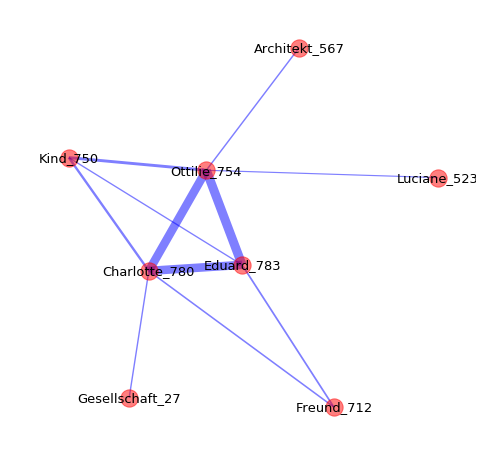

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

def visualize_graph(graph, width_factor=40):
    """
    Visualisiert das Netzwerk.
    Parameter
    ---------
    graph : Graph-Objekt
    """
    fig = plt.figure(figsize=(8,8))
    #Kantendicke anhand des Kantengewichts berechnen
    widths = [dic['weight']/graph.size(weight='weight')*width_factor for (p1, p2, dic) in graph.edges(data=True)]
    #Layout-Algorithmus anwenden
    pos = nx.spring_layout(graph, k=1.5)
    #Netzwerk plotten und speichern
    nx.draw_networkx(graph, pos, width = widths, font_size=13, alpha=0.5, edge_color="blue")
    plt.axis('off')
    plt.savefig("network.png", dpi=100)

#visualize_graph(graph)
    
#Interaktive Visualisation mit ipywidgets
def interactive_visualisation(file, node_filter=10, edge_filter=0.3, width_factor=40):
    graph = make_graph(file, node_filter, edge_filter)
    visualize_graph(graph, width_factor)

interact(interactive_visualisation, file=fixed("interactions.txt"), node_filter=(0,200), edge_filter=(0.0, 1.0), width_factor=(1,100,10))


## Ausblick: Berechnung von Netzwerkmetriken


Ausgehend von einem NetworkX-Graphobjekt können diverse Funktionen zur Berechnung von Netzwerkmetriken angewandt werden. Eine große Zahl solcher Algorithmen ist in NetworkX vorhanden. Mithilfe solcher Netzwerkmetriken können strukturelle Eigenschaften eines Netzwerks als Zahlenwerte ausgedrückt und analysiert werden.

Als zwei einfache Beispiele werden hier die Berechnung der Gradzentralität, die bereits zur Filterung des Graphen verwendet wurde, sowie die Netzwerk-Dichte genannt. Es existiert eine Vielzahl weiterer Maße zur Netzwerkanalyse, wobei häufig mehrere in Kombination verwendet werden.

Die Gradzentralität kann für jeden Knoten einzeln berechnet werden und gibt die Anzahl aller an dem Knoten anliegenden Kanten, als Bruchteil aller möglichen Kanten für diesen Knoten, an. Gibt es einen Knoten mit der Gradzentralität 1, während alle anderen Knoten einen geringeren Wert haben, so deutet das auf ein sternförmiges Netzwerk hin. Hat jeder Knoten den Wert 1, so ist das Netzwerk vollständig vernetzt.

In diesem Beispiel sind also "Charlotte" und "Ottilie" die am stärksten vernetzten Knoten. Die Werte der Gradzentralität sind natürlich auch von der Netzwerkfilterung abhängig.

Andere Maße, wie die Netzwerkdichte, beziehen sich auf ein Netzwerk als Ganzes. Die Dichte gibt das Verhältnis der Anzahl aller tatsächlich im Netzwerk realisierten Kanten zu der Anzahl aller theoretisch möglichen Kanten an. Folglich kann sich ein Wert zwischen 0 (Netzwerk ohne Kanten) und 1 (vollständig vernetzter Graph) ergeben.

In [7]:
degrees = nx.degree_centrality(graph)
print(degrees)
density = nx.density(graph)
print(density)


{'Ottilie_754': 0.7142857142857142, 'Gesellschaft_27': 0.14285714285714285, 'Luciane_523': 0.14285714285714285, 'Kind_750': 0.42857142857142855, 'Architekt_567': 0.14285714285714285, 'Freund_712': 0.2857142857142857, 'Eduard_783': 0.5714285714285714, 'Charlotte_780': 0.7142857142857142}
0.39285714285714285
